# Assessing Changes in Encircled Energy for JWST Abs Flux Cal Programs

Changes in telescope wavefront can affect PSF encircled energy, typically at levels of a fraction of a percent. 

STPSF includes a function to display wavefront changes during a specified science program. This function `show_wfs_during_program` makes a plot so you can see how much the telescope varied in a given time period compared to when that program's observations took place. 

This notebook includes a new function, `calc_delta_ee_during_program`, which goes one step further and uses the WFS data to compute the expected encircled energy at the time of each observation in that program. 

First, let's demonstrate the `show_wfs_during_program` included with STPSF: 

In [1]:
%matplotlib inline
import stpsf

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-072 CANNOT BE CHECKED AGAINST ONLINE VERSION


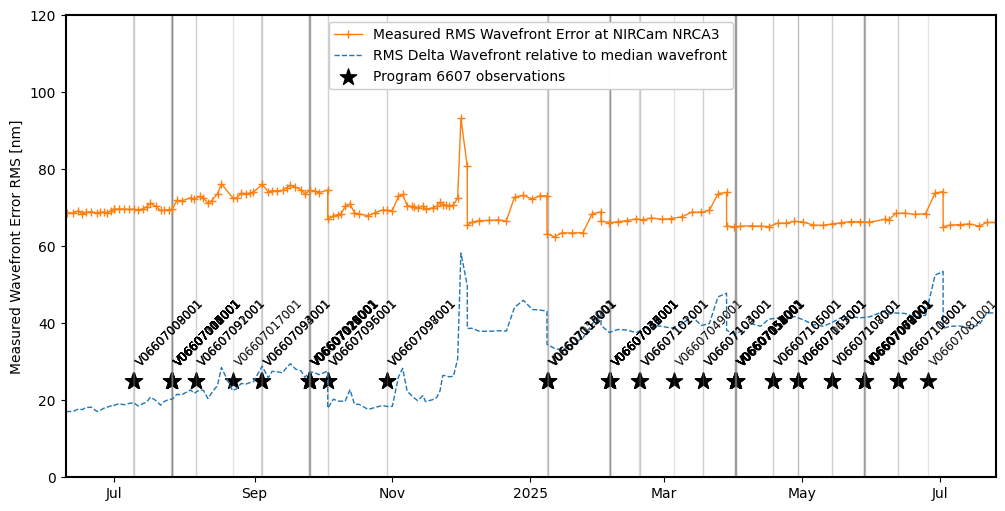

In [2]:
stpsf.trending.show_wfs_during_program(6607)  # 6607 is cycle 3 Abs Flux Cal repeatability

## Function definition

Now let's implement the `calc_delta_ee_during_program` function.  

This function does the requested calculations, makes some plots, and returns the results in a table. 

In [3]:
from stpsf.trending import *

def calc_delta_ee_during_program(
    program, instrument, aperture_radii = (0.25, 0.5), sky_annulus_radii = (2, 2.5), 
    visits = None,
    verbose=False, ref_wavefront_date=None, ref_wavefront_visit=None, start_date=None, end_date=None
):
    """Show WFS data and compute encircled energy for the entire time interval in which a given program was observed.

    This is an expanded variant of show_wfs_during_program

    Plots time series of the WFS measured RMS WFE as seen in NIRCam, the start and end times
    of all the observations in that program, and the delta wavefront RMS relative to either
    the median wavefront during that time period, or to a specifed date. Then compute the 
    encircled energies in the specified filters. 

    This is a derived and expanded variant of show_wfs_around_obs.

    Parameters
    ----------
    program : str or int
        Program ID number
    instrument : STPSF Instrument instance
        An instrument object, pre-configured to set the filter, field point, and any other 
        relevant options (coronagraph masks or spectrograph slits, etc)
    aperture_radii : list of floats
        Photometry aperture radii to compute encircled energies for
    sky_annulus_radii : list of floats
        inner and outer radii for the sky annulus used in aperture photometry
    visits : list of strings
        List of visit numbers, like "V01234005006", to do calculations for. 
        This is an optional input used to reduce calculation times for programs containing
        many different kinds of visits. 
    verbose : str
        be more verbose in output?
    ref_wavefront_date : date-like str or None
        Optional, to specify which date's wavefront sensing should be used as
        the reference wavefront for computation of the plotted delta WFE RMS.
        The closest wavefront in time to the specified date will be used.
        If not set, the median wavefront over the entire time period will be used.
    ref_wavefront_visit : str
        Another way to specify which date's wavefront sensing should be used as the
        reference. Provide a science visit ID from the program (e.g. "V01234002001")
        and the closest wavefront to the observation start time of that visit will be used.
    start_date, end_date : strings or astropy.time.Time
        Start and/or end dates for the time period to display. If not set,
        reasonable default values will be computed that include all observations
        for that science program plus some padding time on either side.
    """

    print(f"Computing ∆EE for {inst.name}, {inst.filter}")

    ########## This part of the function is a direct copy from show_wfs_during_program ##########
    # Query mast for when the observations took place
    science_visit_table = stpsf.mast_wss.query_program_visit_times(program, verbose=verbose)
    science_visit_table.sort(keys=['start_mjd'])
    if verbose:
        for row in science_visit_table:
            print(f" Found {row['visit_id']} starting at {row['start_mjd'].iso}")

    # Figure out reasonable start and end dates for the time interval to display,
    # or use values provided by the user
    sci_duration = science_visit_table['start_mjd'].max() - science_visit_table['start_mjd'].min()
    plot_padding_time_range = max(sci_duration.to(u.day) * 0.2, 4 * u.day)
    if plot_padding_time_range > 30 * u.day:
        plot_padding_time_range = 30 * u.day # Avoid a padding larger than 30 days

    if start_date is None:
        start_date = science_visit_table['start_mjd'].min() - plot_padding_time_range
    else:
        start_date = astropy.time.Time(start_date)
    if end_date is None:
        end_date = science_visit_table['end_mjd'].max() + plot_padding_time_range
    else:
        end_date = astropy.time.Time(end_date)

    min_date = astropy.time.Time('2022-03-14') #Final Alignment
    if start_date < min_date:
        start_date = min_date

    # Look up wavefront sensing and mirror move corrections for that range
    opdtable = get_opdtable_for_daterange(start_date, end_date)

    # Iterate over the WFS measurements to retrieve the OPDs and RMS WFE
    wfs_dates = []
    rms_obs = []
    opds = []
    for row_index in range(len(opdtable)):
        opd_fn = opdtable[row_index]['fileName']
        try:
            opd, opd_hdul = stpsf.trending._read_opd(opd_fn)
        except FileNotFoundError:
            stpsf.mast_wss.mast_retrieve_opd(opd_fn, verbose=verbose)
            opd, opd_hdul = stpsf.trending._read_opd(opd_fn)

        if opd.shape != (256, 256):  # handle the case for commissioning phasemaps
            # the results from the zoom function preserve the STD between both phase maps and
            # the total sum between the phase maps is proportional to the zoom value
            # by construction there are no OPDs larger than 256x256
            opd = scipy.ndimage.zoom(opd, 256 / opd.shape[0])


        opds.append(opd)
        wfs_dates.append(opdtable[row_index]['date'])
        rms_obs.append(opd_hdul[1].header['RMS_WFE'] * 1000)
    wfs_dates_array = astropy.time.Time(wfs_dates, format='isot')
    opd_array = np.asarray(opds)

    # Compute delta WFE, either relative to median or a specifed date
    if ref_wavefront_visit is not None:
        for row in science_visit_table:
            if row['visit_id'] == ref_wavefront_visit:
                ref_wavefront_date = row['start_mjd'].iso
                if verbose:
                    print(f" Will compare wavefronts relative to {row['visit_id']} starting at {row['start_mjd'].iso}")

    if ref_wavefront_date:
        refdate = astropy.time.Time(ref_wavefront_date)
        delta_times = wfs_dates_array - refdate
        closest = np.argmin(np.abs(delta_times))
        reference_opd = opds[closest]
        ref_label = 'WFS near ' + ref_wavefront_date
        if verbose:
            print(f"Computing delta OPDs relative to date {ref_wavefront_date}, using opd {opdtable[closest]['fileName']}")
    else:
        median_opd = np.median(opd_array, axis=0)
        reference_opd = median_opd
        ref_label = 'median wavefront'
        if verbose:
            print('Computing delta OPDs relative to median OPD over that time period.')

    delta_opds = opd_array - reference_opd
    mask = opd_array.sum(axis=0) != 0
    delta_rmses = [stpsf.utils.rms(d, mask=mask) * 1000 for d in delta_opds]

    # Plot!
    fig, axes = plt.subplots(figsize=(10, 10), ncols=1, nrows=3)
    
    ###### Top panel
    ax = axes[0]
    ax.plot(
        wfs_dates_array.plot_date, rms_obs, '+', color='C1', ls='-', label='Measured RMS Wavefront Error at NIRCam NRCA3'
    )
    ax.plot(
        wfs_dates_array.plot_date,
        delta_rmses,
        'none',
        color='C0',
        ls='--',
        label=f'RMS Delta Wavefront relative to {ref_label}',
    )

    plot_sci_y = 25
    ax.scatter(
        science_visit_table['start_mjd'].plot_date,
        [plot_sci_y] * len(science_visit_table),
        s=150,
        marker='*',
        color='black',
        label=f'Program {program} observations',
    )
    for row in science_visit_table:
        ax.fill_betweenx([0, 120], row['start_mjd'].plot_date, (row['end_mjd']).plot_date, color='gray', alpha=0.2)
        ax.text(row['start_mjd'].plot_date, plot_sci_y + 4, row['visit_id'], rotation=45, fontsize='small', clip_on=True)

    ax.set_ylim(0, 120)
    ax.legend(framealpha=0.99)
    #ax.xaxis.set_major_formatter(matplotlib.dates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.set_ylabel('Measured Wavefront Error RMS [nm]')
    ax.set_xlim(start_date.plot_date, end_date.plot_date)

    ########## This is where the new code begins, to compute EEs at each date ##########
    ax2 = axes[1]
    ees_by_date = np.zeros((len(science_visit_table), len(aperture_radii)), float) + np.nan
    sky_annulus_ees = np.zeros((len(science_visit_table),), float) + np.nan
    for i, row in enumerate(science_visit_table):
        if visits is not None:
            if row['visit_id'] not in visits:
                continue
        print(f"Computing PSF {i+1}/{len(science_visit_table)} for {row['visit_id']} on {row['start_mjd'].isot[0:10]}")
        inst.load_wss_opd_by_date(row['start_mjd'].isot, verbose=False)
        
        psf = inst.calc_psf(fov_pixels=201)
        
        ee_function = stpsf.measure_ee(psf, ext='OVERDIST')  # Use the oversampled extension, including distortions and detector effects etc. 
        for j, rad in enumerate(aperture_radii):
            ees_by_date[i, j] = ee_function(rad)
        sky_annulus_ees[i] = ee_function(sky_annulus_radii[1]) - ee_function(sky_annulus_radii[0])

    # And plot
    for j, rad in enumerate(aperture_radii):
        valid = np.isfinite(ees_by_date[:,j])  # in case we have skipped some visits
        ax2.plot(science_visit_table['start_mjd'].plot_date[valid], ees_by_date[:,j][valid], marker='*', label=f'EE within r={rad:.2f} arcsec', markersize=10)
        ax2.text(science_visit_table['start_mjd'][-1].plot_date, np.mean(ees_by_date[:,j][valid]), 
                f"For r={rad:.2f} arcsec\nMean = {ees_by_date[:,j].mean():.4f},\n range = {np.nanmin(ees_by_date[:,j]):.4f} - {np.nanmax(ees_by_date[:,j]):.4f}\n ",
                color=f"C{j}", horizontalalignment='right')
    
    ax2.set_ylabel("Encircled Energy")
    ax2.set_title(f"EE for {inst.name} + {inst.filter}")
    ax2.set_ylim(np.nanmin(ees_by_date)-0.02, np.nanmax(ees_by_date)+0.03)

    axes[2].plot(science_visit_table['start_mjd'].plot_date[valid], sky_annulus_ees[valid], color='gray', label="EE in sky annulus")
    axes[2].set_title(f"EE in sky annulus, from {sky_annulus_radii[0]:.2f} to {sky_annulus_radii[1]:.2f} arcsec")
    axes[2].set_ylim(max(np.nanmin(sky_annulus_ees)-0.01, 0), np.nanmax(sky_annulus_ees)+0.01)
    axes[2].text(science_visit_table['start_mjd'][-1].plot_date, np.nanmean(sky_annulus_ees), 
                f"For r={sky_annulus_radii[0]:.2f} to {sky_annulus_radii[1]:.2f} arcsec\nMean = {np.nanmean(sky_annulus_ees):.4f},\n range = {np.nanmin(sky_annulus_ees):.4f} - {np.nanmin(sky_annulus_ees):.4f}\n ",
                color="gray", horizontalalignment='right')

    for ax in axes[1:]:
        #ax.xaxis.set_major_formatter(axes[0].xaxis.get_major_formatter())
        ax.set_xlim(start_date.plot_date, end_date.plot_date)
        ax.set_ylabel("Encircled Energy")
        ax.legend()
    date_form = matplotlib.dates.DateFormatter('%Y-%b-%d')
    for ax in axes:     
        ax.xaxis.set_major_locator(matplotlib.dates.AutoDateLocator(maxticks=8))
        ax.xaxis.set_major_formatter(date_form)

    axes[0].set_xlabel(f"Date")
    fig.autofmt_xdate()
    fig.tight_layout()
        
    
    result_table = astropy.table.Table( (science_visit_table['visit_id'],
                                         science_visit_table['start_mjd'],
                                         ))
    for j, rad in enumerate(aperture_radii):
         result_table.add_column(ees_by_date[:,j], name=f'EE_within_r={rad:.1f}')
    result_table.add_column(sky_annulus_ees, name=f'sky_annulus_EE_in_r={sky_annulus_radii[0]:.2f}_to_{sky_annulus_radii[1]:.2f}')
    
    return result_table

## Set up an instrument model

One of the inputs to that function is an STPSF instrument model. This is how you specify the desired instrument, filter, and optional parameters such as masks or slits. You can also specify a particular position (e.g. named subarray aperture), if you want. 

In [4]:
inst = stpsf.NIRCam()
inst.filter = 'F212N'
inst.aperturename = 'NRCA1_SUB160'

In [5]:
# Optional
# STPSF has a one-liner to configure instrument model, filters, subarray etc to match some given data file
# You can use this instead of manually setting up the instrument model, if you want

# inst = stpsf.setup_sim_to_match_file('jw07671-o021_t003_miri_f770w_i2d.fits')


## Compute Encircled Energies over time

And now we can compute the EEs for each visit in a specified program:

Computing ∆EE for NIRCam, F212N
Computing PSF 1/69 for V06607009001 on 2024-07-09
Computing PSF 2/69 for V06607008001 on 2024-07-09
Computing PSF 3/69 for V06607007001 on 2024-07-26
Computing PSF 4/69 for V06607001001 on 2024-07-26
Computing PSF 5/69 for V06607002001 on 2024-07-26
Computing PSF 6/69 for V06607003001 on 2024-07-26
Computing PSF 7/69 for V06607004001 on 2024-07-26
Computing PSF 8/69 for V06607005001 on 2024-07-26
Computing PSF 9/69 for V06607006001 on 2024-07-26
Computing PSF 10/69 for V06607010001 on 2024-07-26
Computing PSF 11/69 for V06607111001 on 2024-07-26
Computing PSF 12/69 for V06607091001 on 2024-08-06
Computing PSF 13/69 for V06607092001 on 2024-08-06
Computing PSF 14/69 for V06607017001 on 2024-08-22
Computing PSF 15/69 for V06607093001 on 2024-09-04
Computing PSF 16/69 for V06607094001 on 2024-09-04
Computing PSF 17/69 for V06607019001 on 2024-09-25
Computing PSF 18/69 for V06607020001 on 2024-09-25
Computing PSF 19/69 for V06607021001 on 2024-09-25
Computin

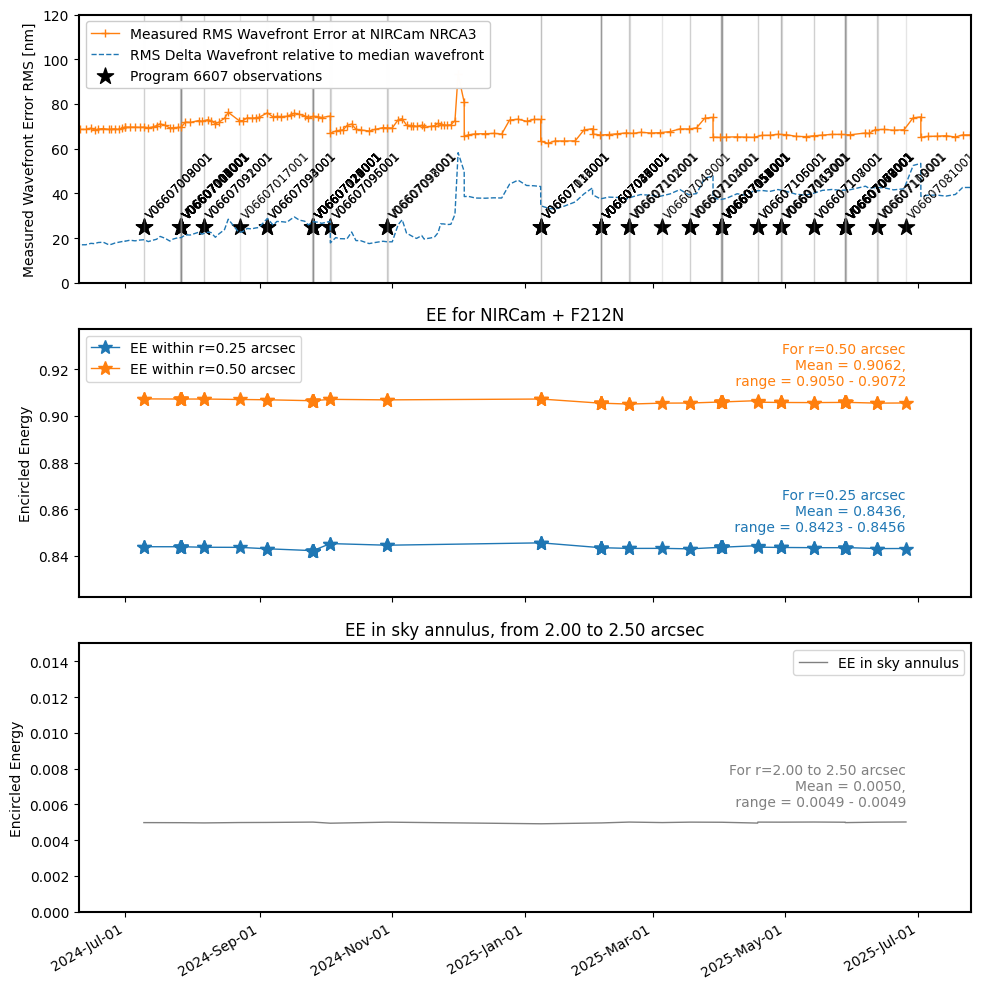

In [6]:
result_table = calc_delta_ee_during_program(6607, inst, 
                                            aperture_radii=[0.25, 0.5], sky_annulus_radii=[2, 2.5])  # Tweak these to match whatever you're using 

In [7]:
result_table

visit_id,start_mjd,EE_within_r=0.2,EE_within_r=0.5,sky_annulus_EE_in_r=2.00_to_2.50
str12,Time,float64,float64,float64
V06607009001,60500.49165130787,0.8439329011626818,0.907243097359146,0.004979193429057949
V06607008001,60500.54920385416,0.8439329011626816,0.907243097359146,0.00497919342905806
V06607007001,60517.26478282407,0.8439300311637978,0.9071737162825325,0.004974988410521131
V06607001001,60517.374933831015,0.8439300311637978,0.9071737162825325,0.004974988410521131
V06607002001,60517.40495373843,0.8439300311637978,0.9071737162825325,0.004974988410521131
V06607003001,60517.427673680555,0.8439300311637978,0.9071737162825325,0.004974988410521131
V06607004001,60517.4389803588,0.8439300311637978,0.9071737162825325,0.004974988410521131
V06607005001,60517.46479366898,0.8439300311637978,0.9071737162825325,0.004974988410521131
V06607006001,60517.49036994213,0.8439300311637978,0.9071737162825325,0.004974988410521131


## Optional, let's be more efficient about which visits to simulate

In the case of the 6607 program used in this demo, most of the visits are not actually using that particular instrument configuration, so it's being inefficient and doing extra calculations it doesn't need to. 

We can avoid this (and thus speed up runtime) by giving a list of which specific subset of visits to compute EEs for,

For example, looking at the APT file for 6607 we can see the NRCA SW visits are as follows: 

In [8]:
visits_nrca_sw = ['V06607003001', 'V06607021001', 'V06607037001', 'V06607053001', 'V06607069001', ]

Computing ∆EE for NIRCam, F212N
Computing PSF 6/69 for V06607003001 on 2024-07-26
Computing PSF 19/69 for V06607021001 on 2024-09-25
Computing PSF 34/69 for V06607037001 on 2025-02-05
Computing PSF 46/69 for V06607053001 on 2025-04-01
Computing PSF 60/69 for V06607069001 on 2025-05-28


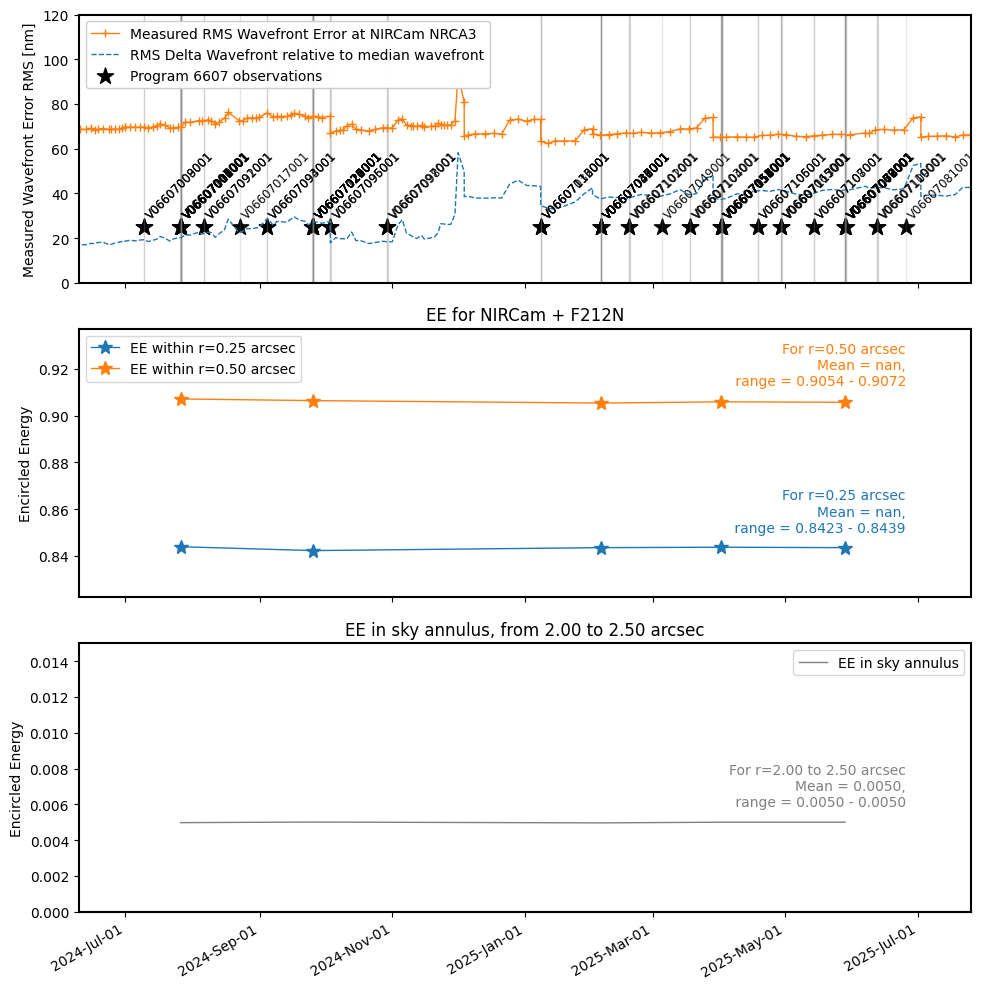

In [9]:
result_table = calc_delta_ee_during_program(6607, inst, 
                                            aperture_radii=[0.25, 0.5], sky_annulus_radii=[2, 2.5],
                                            visits = visits_nrca_sw)  # Tweak these to match whatever you're using 